# Fast rollout in Fortran

In [1]:
import numpy as np
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint
import matplotlib.pyplot as plt
import copy

np.random.seed(42)

In [2]:
import fast_rollout

print(fast_rollout.rollout.__doc__)

cost = rollout(con,init_x,targ_x,obs,[obs_n,obs_r_frac,x_len,con_len,n,ts])

Wrapper for ``rollout``.

Parameters
----------
con : input rank-1 array('d') with bounds (con_len)
init_x : input rank-1 array('d') with bounds (x_len)
targ_x : input rank-1 array('d') with bounds (-1 + x_len)
obs : input rank-2 array('f') with bounds (obs_n,-1 + x_len)

Other Parameters
----------------
obs_n : input int, optional
    Default: shape(obs, 0)
obs_r_frac : input float, optional
    Default: 15.0
x_len : input int, optional
    Default: shape(init_x, 0)
con_len : input int, optional
    Default: shape(con, 0)
n : input int, optional
    Default: 50
ts : input float, optional
    Default: 0.1

Returns
-------
cost : float



In [3]:
def rollout(x_dot, cur_point, ts=0.1, th=50):
    x_c = copy.copy(cur_point)
    x_dot_r = x_dot.reshape(-1)
    cost_v = 0.0
    for i in range(0, th):
        jac_v = J_vehicle(x_c)
        nextstep = np.matmul(jac_v, x_dot_r) * ts
        x_c = x_c + nextstep
        norm_dist = np.linalg.norm(x_c[:2] - end_point)
        obs_ratio = 15.0 / (
            ts * (i + 1) * (np.min(np.linalg.norm(x_c[:2] - obs_np, axis=1)))
        )
        # obs_ratio=np.max((1./(2.5*sigma))*(np.exp(-0.5*(np.linalg.norm(x_c[:2]-obs_np,axis=1)/sigma)**2)))
        # obs_ratio=np.max(np.exp(-(np.linalg.norm(x_c[:2]-obs_np,axis=1))**2))
        if norm_dist < 0.1:
            return cost_v
        cost_v = cost_v + (norm_dist) + (obs_ratio)
    return cost_v

## Environment settings

In [4]:
# x, y, turning-angle
start_point = np.array([38.0, 38.0, -2.0])
end_point = np.array([20.0, 20.0])

random_x = np.random.uniform(21, 37, 50).reshape((-1, 1))
random_y = np.random.uniform(21, 37, 50).reshape((-1, 1))
obs_np = np.concatenate([random_x, random_y], axis=1)

## rollout and vehicle jacobian

In [5]:
def J_vehicle(x_c):
    ret_array = np.array([[np.cos(x_c[-1]), 0.0], [np.sin(x_c[-1]), 0.0], [0.0, 1.0]])
    return ret_array


def rollout_sc(control, start, ts=0.1, th=50):
    cur_state = copy.copy(start)
    points_list = []
    for i in range(th):
        J = J_vehicle(cur_state)
        x_dot = np.matmul(J, control)
        cur_state += x_dot * ts
        points_list.append(copy.copy(cur_state))
    return np.array(points_list)


def plot_robot(robot_poses, obstacles=None, target=None, lw=5):
    if obstacles is not None:
        plt.scatter(obstacles[:, 0], obstacles[:, 1], c="r")
    plt.plot(robot_poses[:, 0], robot_poses[:, 1], c="m", lw=lw)
    plt.scatter(robot_poses[0, 0], robot_poses[0, 1], c="b", label="start")
    if target is not None:
        plt.scatter(target[0], target[1], c="g")

In [6]:
# ---------------------------------i

In [7]:
control = np.array([1.0, -0.1])
rollout(control, start_point)

1358.851914063271

In [8]:
def ttc_rollout(control, start, ts=0.1, th=50):
    cur_state = copy.copy(start)
    count = 0.0
    dist_sum = 0.0
    for i in range(th):
        J = J_vehicle(cur_state)
        x_dot = np.matmul(J, control)
        cur_state += x_dot * ts
        count += 1.0
        d_cost = np.linalg.norm(cur_state[:2] - end_point)
        # dist_sum+=d_cost
        dist = np.linalg.norm(cur_state[:2] - obs_np, axis=1)
        if np.min(dist) < 0.5:
            # cost=(dist_sum/count)+(50./((count*ts)))
            cost = d_cost + (50.0 / ((count * ts) ** 2))
            return cost
    # cost=(dist_sum/count)#+(5./((count*ts)))
    cost = d_cost
    return cost


def rollout(x_dot, cur_point, ts=0.1, th=50):
    x_c = copy.copy(cur_point)
    x_dot_r = x_dot.reshape(-1)
    cost_v = 0.0
    for i in range(0, th):
        jac_v = J_vehicle(x_c)
        nextstep = np.matmul(jac_v, x_dot_r) * ts
        x_c = x_c + nextstep
        norm_dist = np.linalg.norm(x_c[:2] - end_point)
        obs_ratio = 15.0 / (
            ts * (i + 1) * (np.min(np.linalg.norm(x_c[:2] - obs_np, axis=1)))
        )
        # obs_ratio=np.max((1./(2.5*sigma))*(np.exp(-0.5*(np.linalg.norm(x_c[:2]-obs_np,axis=1)/sigma)**2)))
        # obs_ratio=np.max(np.exp(-(np.linalg.norm(x_c[:2]-obs_np,axis=1))**2))
        if norm_dist < 0.1:
            return cost_v
        cost_v = cost_v + (norm_dist) + (obs_ratio)
    return cost_v

## test control

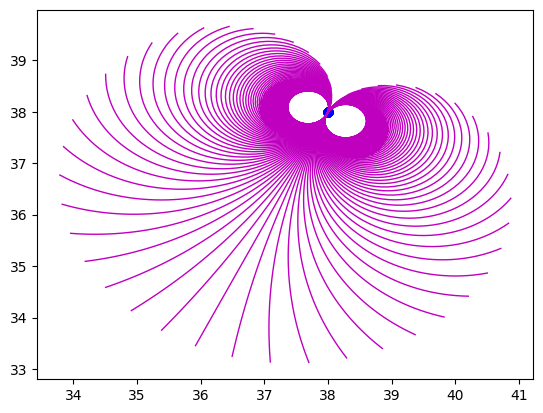

In [9]:
# test holding different controls
for step in np.arange(-3.1, 3.1, 0.05):
    control = np.array([1.0, step])
    points_np = rollout_sc(control, start_point)
    # add start point
    points_np = np.vstack([start_point[None, :], points_np])
    plot_robot(points_np, lw=1)
plt.show()

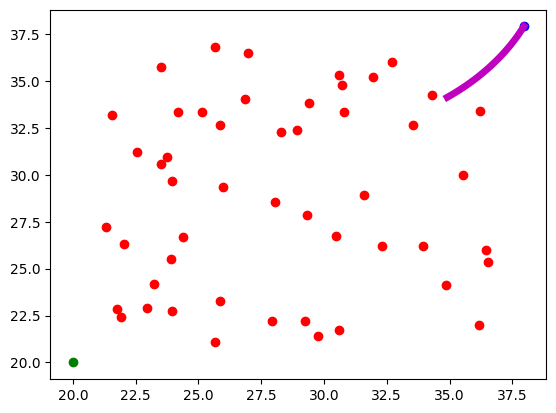

In [10]:
control = np.array([1.0, -0.1])

plot_robot(rollout_sc(control, start_point), obstacles=obs_np, target=end_point)

In [11]:
%%timeit
fast_rollout.rollout(
    control,
    init_x=start_point,
    targ_x=end_point,
    obs=obs_np,
)

33.2 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
single_con = np.array([1.5, 0.0])
ubounds = np.array([1.5, 1.0])
lbounds = np.array([0.0, -1.0])
ubounds = ubounds.reshape(-1)
lbounds = lbounds.reshape(-1)
LinBounds = Bounds(lbounds, ubounds)


def integrate_next_step(x_0, x_dot, ts_c=0.1):
    x_c = copy.copy(x_0)
    jac_v = J_vehicle(x_c)
    x_c += np.matmul(jac_v, x_dot) * ts_c
    return x_c

[21.50286697 31.18256658 -2.        ] [29.13713106 35.52106358]
at  168
CPU times: user 143 ms, sys: 0 ns, total: 143 ms
Wall time: 142 ms


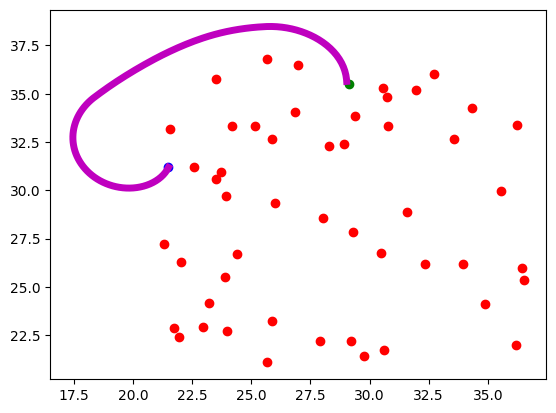

In [13]:
%%time
start_point = np.array([38.0, 38.0, -2.0])
end_point = np.array([20.0, 20.0])


cur_con = np.array([1.5, 0.0])


cur_point = start_point.copy()

start_point = np.random.uniform(21, 37, 3)
start_point[-1] = -2.0
end_point = np.random.uniform(21, 37, 2)

print(start_point, end_point)

cur_point = copy.copy(start_point)
pos_list = []
vel_list = []
for i in range(1500):
    pos_list.append(copy.copy(cur_point))
    res = minimize(
        fast_rollout.rollout,
        cur_con,
        method="slsqp",
        args=(cur_point, end_point, obs_np),
        bounds=LinBounds,
        options={"ftol": 0.1},
    )
    #     res=minimize(rollout,cur_con,method='slsqp',args=(cur_point),bounds=LinBounds,options={'ftol':0.1})
    cur_con = copy.copy(res.x)
    cur_con = res.x
    next_point = integrate_next_step(cur_point, cur_con)
    cur_point = next_point
    vel_list.append(cur_con)
    if np.linalg.norm(cur_point[:2] - end_point) < 0.1:
        break
print("at ", i)

plot_robot(np.array(pos_list), obstacles=obs_np, target=end_point)

## Speed up forward propagate calculation

In [14]:
# using forward propagate implemented in cython

import forward_prop_traj

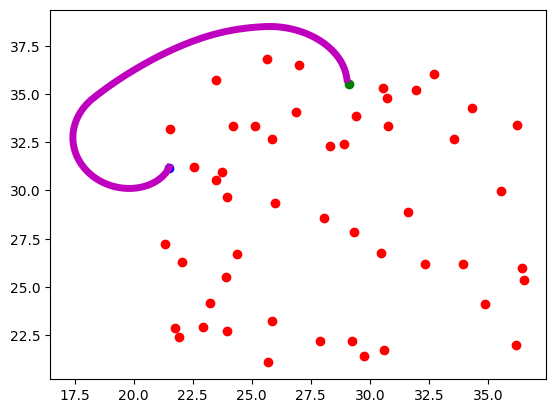

CPU times: user 191 ms, sys: 9 ms, total: 200 ms
Wall time: 194 ms


In [15]:
%%time

r = forward_prop_traj.prop_traj(
    start_point=start_point,
    end_point=end_point,
    start_con=cur_con,
    N=2000,
    ftol=0.1,
    LinBounds=LinBounds,
    obs_np=obs_np,
)

pos_np = np.array(r[0])
vel_np = np.array(r[1])

plot_robot(pos_np, obstacles=obs_np, target=end_point)
plt.show()